<a href="https://colab.research.google.com/github/ragul-n/Analysis-of-Ashoka-University-Confession-page/blob/master/Extracting_Sentiments_from_confessions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install instaloader
!pip install ftfy
!pip install text2emotion


In [ ]:
!pip install --upgrade azure-cognitiveservices-vision-computervision
!pip install pillow
!pip install azure-ai-textanalytics==5.1.0

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import shutil
import os
import random
try:
 from PIL import Image
except ImportError:
 import Image
import text2emotion as te
import cv2
import ftfy
import uuid
import nltk
import random
import IPython.display

from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials

from array import array
import os
from PIL import Image
import sys
import time


nltk.download("vader_lexicon")

from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
image_list=[]

for file in os.listdir("/content/drive/MyDrive/au.rants.23"):
    if file.endswith(".jpg"):
        image_list.append(os.path.join("/content/drive/MyDrive/au.rants.23", file))

len(image_list)

1365

OCR with Microsoft Azure

In [ ]:
'''
Authenticate
Authenticates your credentials and creates a client.
'''
subscription_key = "ab1b27f9f3fe48a6aac6b3de0224e94a"
endpoint = "https://ragul.cognitiveservices.azure.com/"


computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))



def read_image(read_image_path):

    # Open the image
    read_image = open(read_image_path, "rb")

    # Call API with image and raw response (allows you to get the operation location)
    read_response = computervision_client.read_in_stream(read_image, raw=True)
    # Get the operation location (URL with ID as last appendage)
    read_operation_location = read_response.headers["Operation-Location"]
    # Take the ID off and use to get results
    operation_id = read_operation_location.split("/")[-1]

    # Call the "GET" API and wait for the retrieval of the results
    while True:
        read_result = computervision_client.get_read_result(operation_id)
        if read_result.status.lower () not in ['notstarted', 'running']:
            break
        
    # Print results, line by line
    string=""
    
    if read_result.status == OperationStatusCodes.succeeded:
        for text_result in read_result.analyze_result.read_results:
            for line in text_result.lines:
                string = string + " " + line.text
                #print(line.bounding_box)
    return string

read_image(image_list[0])

' CUPCAKES ROCK'

In [ ]:
sentiments=[]

sia = SentimentIntensityAnalyzer()

count=0
length= str(len(image_list))
info = display(str(count) + "/"+ length, display_id=True)

for image in image_list:

    info.update(str(count) + "/"+ length)

    string = read_image(image)

    temp=te.get_emotion(string)
    temp.update(sia.polarity_scores(string))
    temp.update({"rant":string})

    sentiments.append(temp)
    count+=1
      
    

'1364/1365'

In [ ]:
sentiments[976]

{'Angry': 0.09,
 'Fear': 0.36,
 'Happy': 0.09,
 'Sad': 0.36,
 'Surprise': 0.09,
 'compound': 0.5232,
 'neg': 0.126,
 'neu': 0.712,
 'pos': 0.162,
 'rant': " I am sorry for saying this. There are some people who are opening petitions and not signing them. How petty and selfish can you be? In times of need, who will support you, when you're not ready to support anyone? This is not a hateful message. But please be mindful about others situations. Let's all be wholesome."}

Saving Dataset

##Microsoft Azure's Text Analytics

In [ ]:
key = "384eb6ff06b9458bb15231adce28ba5f"
endpoint = "https://ragul-text.cognitiveservices.azure.com/"

from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential

def authenticate_client():
    ta_credential = AzureKeyCredential(key)
    text_analytics_client = TextAnalyticsClient(
            endpoint=endpoint, 
            credential=ta_credential)
    return text_analytics_client

client = authenticate_client()



def sentiment_analysis(rant, client):


    if len(rant) != 0:
        documents = [rant]
        response = client.analyze_sentiment(documents=documents)[0]
        sentiment= {
            "positive":response.confidence_scores.positive,
            "neutral":response.confidence_scores.neutral,
            "negative":response.confidence_scores.negative,
        }

        return sentiment
    else:
        return {
            "positive":np.nan,
            "neutral":np.nan,
            "negative":np.nan,
        }


sentiments=[]

count=0
length= str(len(image_list))
info = display(str(count) + "/"+ length, display_id=True)

for rant in data["rant"]:
    info.update(str(count) + "/"+ length)
    sentiment = sentiment_analysis(rant, client)
    sentiment.update({"rant":rant})
    sentiments.append(sentiment)
    count+=1


'1364/1365'

In [ ]:
sentiments

In [ ]:

data= pd.DataFrame(sentiments)
data["image_adress"] = image_list

import re
from datetime import datetime

date_list = []
for img in image_list:
    match = re.search(r'\d{4}-\d{2}-\d{2}', img)
    date = datetime.strptime(match.group(), '%Y-%m-%d').date()
    date_list.append(date)

data["Date"] = date_list
data['Date'] = pd.to_datetime(data['Date'], format = '%Y-%m-%d')

data= data.drop("image_adress", axis=1)
data= data.assign(id= data['rant'].astype('category').cat.codes)

data.head()

,positive,neutral,negative,rant,Date,id
0,0.56,0.41,0.03,CUPCAKES ROCK,2021-06-25,145
1,0.04,0.94,0.02,Would you connect with your ex on Linkedin? A...,2021-06-25,1098
2,0.00,0.00,1.00,"""I have a crush on this, I have a crush on th...",2021-06-25,3
3,0.35,0.13,0.52,"AHOY I have a phone worth 8k, a laptop that I...",2021-06-25,39
4,0.02,0.44,0.54,It's not real you've never even met the dude,2021-06-25,649


In [ ]:
data.to_csv("/content/drive/MyDrive/au.rants.23/emotions.csv")

Visualizing Dataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Emotions')

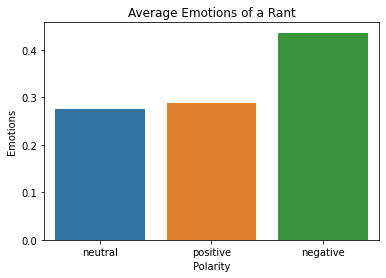

In [ ]:
sentiments = data.mean().drop("id").sort_values()
index=list(sentiments.index)

ax=sns.barplot(x=index, y=sentiments.values)
ax.set_title("Average Emotions of a Rant")
ax.set_xlabel("Polarity")
ax.set_ylabel("Emotions")

In [ ]:
import matplotlib.dates as md

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

mean_by_date= data.groupby("Date").agg(np.mean)

fig, ax= plt.subplots(figsize=(10,6))

ax=sns.lineplot(y=moving_average(mean_by_date["positive"].values,5),color="green", x=mean_by_date.index[4:] , label="Positive")
ax.axhline(data.positive.mean(), ls="--", color="green")

ax=sns.lineplot(y=moving_average(mean_by_date["neutral"].values, 5), x=mean_by_date.index[4:],  label="neutral",  color="blue" )
ax.axhline(data.neutral.mean(), ls="--", color="blue")

ax=sns.lineplot(y=moving_average(mean_by_date["negative"].values, 5),color="red", x=mean_by_date.index[4:],  label="Negative", ax=ax, alpha=0.7 )
ax.axhline(data.negative.mean(), ls="--", color="red" )


# specify the position of the major ticks at the beginning of the week
ax.xaxis.set_major_locator(md.WeekdayLocator(byweekday = 1))
# specify the format of the labels as 'year-month-day'
ax.xaxis.set_major_formatter(md.DateFormatter('%Y-%m-%d'))
# (optional) rotate by 90° the labels in order to improve their spacing
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 90)

# specify the position of the minor ticks at each day
ax.xaxis.set_minor_locator(md.DayLocator(interval = 1))

# set ticks length
ax.tick_params(axis = 'x', which = 'major', length = 10)
ax.tick_params(axis = 'x', which = 'minor', length = 5)

ax.text(mean_by_date.index[-1], 0.42, "Mean: Negative")
ax.text(mean_by_date.index[-1], 0.29, "Mean: Positve")
ax.text(mean_by_date.index[-1], 0.26, "Mean: Neutral")


ax.set_title("Average sentiments by Date")

NameError: ignored

In [ ]:
#len(moving_average(mean_by_date["negative"].values, 5))
len(mean_by_date["negative"].values)

75

In [ ]:
def opinion_mining(rant, id, client):

    documents = [rant]

    if len(rant) ==0:
        return  {
                        "rant_id": id,
                        "target_text": np.nan,
                        "target_sentiment": np.nan,
                        "assesment_text": np.nan,
                        "assesment_sentiment": np.nan,

                        "target_positive_score": np.nan,
                        "target_negative_score": np.nan,
                        "assesment_positive_score":  np.nan,
                        "assesment_negative_score": np.nan
                    }

    result = client.analyze_sentiment(documents, show_opinion_mining=True)
    doc_result = [doc for doc in result if not doc.is_error]

    positive_reviews = [doc for doc in doc_result if doc.sentiment == "positive"]
    negative_reviews = [doc for doc in doc_result if doc.sentiment == "negative"]

    positive_mined_opinions = []
    mixed_mined_opinions = []
    negative_mined_opinions = []

    for document in doc_result:
        
        for sentence in document.sentences:
          
            for mined_opinion in sentence.mined_opinions:
                target = mined_opinion.target

                for assessment in mined_opinion.assessments:
                    opnion= {
                        "rant_id": id,
                        "target_text": target.text,
                        "target_sentiment":target.sentiment,
                        "assesment_text":assessment.text,
                        "assesment_sentiment": assessment.sentiment,

                        "target_positive_score": target.confidence_scores.positive,
                        "target_negative_score":target.confidence_scores.negative,
                        "assesment_positive_score": assessment.confidence_scores.positive,
                        "assesment_negative_score": assessment.confidence_scores.negative
                    }

                    return opnion


opnions=[]

count=0
length= str(len(image_list))
info = display("Compleated: "+str(count) + "/"+ length, display_id=True)   
          
for (rant, id) in data.loc[: , ["rant", "id"]].values:
    
    opnions.append(opinion_mining(rant, id, client))
    count+=1
    info.update(str(count) + "/"+ length)   

    
opnions = list(filter(None, opnions))


'1365/1365'

In [ ]:
opnions = pd.DataFrame(opnions)
opnions= opnions.merge(data.loc[:, ["id", "Date"]], left_on="rant_id", right_on= "id").drop("id", axis=1)
opnions.to_csv("/content/drive/MyDrive/au.rants.23/opnion.csv")

In [ ]:
opnions.head()

,rant_id,target_text,target_sentiment,assesment_text,assesment_sentiment,target_positive_score,target_negative_score,assesment_positive_score,assesment_negative_score,Date_x,Date_y
0,1337,suspense,negative,killing,negative,0.02,0.98,0.02,0.98,2021-06-25,2021-06-25
1,709,vibe,positive,positive,positive,1.00,0.00,1.00,0.00,2021-06-25,2021-06-25
2,959,humans,positive,worthwhile,positive,1.00,0.00,1.00,0.00,2021-06-26,2021-06-26
3,854,guy,positive,like,positive,1.00,0.00,1.00,0.00,2021-06-26,2021-06-26
4,208,copy,negative,cheap,negative,0.21,0.79,0.21,0.79,2021-06-27,2021-06-27


In [ ]:
temp=opnions.groupby('target_text')["target_positive_score", "target_negative_score", "assesment_positive_score", "assesment_negative_score"].agg(np.mean)

temp.target_negative_score.sort_values(ascending=False)[50:100]

In [ ]:


entities=[]

count=0
length= str(len(image_list))
info = display("Compleated: "+str(count) + "/"+ length, display_id=True)   
          

for (rant, id, date) in data.loc[: , ["rant", "id", "Date"]].values:
    if len(rant) ==0:
        continue

    documents = [rant]

    response = client.recognize_pii_entities(documents, language="en")
    result = [doc for doc in response if not doc.is_error]
    for doc in result:
        for entity in doc.entities:
            ent= {
                "rant_id": id,
                "entity": entity.text,
                "category": entity.category,
                "subcategory": np.nan,
                "confidence_score":entity.confidence_score,
                "Date":date
            }
            entities.append(ent)

    try:
        result = client.recognize_entities(documents = documents)[0]

        for entity in result.entities:

            ent= {
                "rant_id": id,
                "entity": entity.text,
                "category": entity.category,
                "subcategory": entity.subcategory,
                "confidence_score":entity.confidence_score,
                "Date":date
            }

            entities.append(ent)
    except Exception as err:
        print("Encountered exception. {}".format(err))

    count+=1
    info.update("Compleated: "+str(count) + "/"+ length) 



'Compleated: 1358/1365'

In [ ]:
entities_df= pd.DataFrame(entities)
entities_df.to_csv("/content/drive/MyDrive/au.rants.23/entities.csv")

In [ ]:
entities_df[entities_df.category=="PersonType"]

,rant_id,entity,category,subcategory,confidence_score,Date
0,1098,ex,PersonType,NaN,0.95,2021-06-25
2,1098,friend,PersonType,NaN,0.97,2021-06-25
3,1098,ex,PersonType,None,0.94,2021-06-25
5,1098,friend,PersonType,None,0.99,2021-06-25
7,3,admin,PersonType,None,0.94,2021-06-25
...,...,...,...,...,...,...
3703,804,Professor,PersonType,None,0.98,2021-05-22
3705,394,mumbai,PersonType,NaN,0.74,2021-05-23
3706,394,delhi,PersonType,NaN,0.77,2021-05-23
3707,394,mumbai,PersonType,None,0.85,2021-05-23
